## Creating Structure or Streamlit Application

### Initializations

In [22]:
import speech_recognition as sr
from tensorflow.keras.models import Sequential, load_model
import numpy as np
import pandas as pd
import plotly.express as px

In [10]:
model_lr = load_model('../data/model_l.hd/')

In [11]:
model_sr = load_model('../data/model_s.hd/')

In [12]:
import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin

class WordVectorTransformer(TransformerMixin,BaseEstimator):
    def __init__(self, model="en_trf_distilbertbaseuncased_lg"):    #put bert embeddings here
        self.model = model
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        nlp = spacy.load(self.model)
        return np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in X])

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [14]:
bertvect = WordVectorTransformer()

In [15]:
analyzer = SentimentIntensityAnalyzer()

In [29]:
def combine_predict(sentence):
    sentence = [[sentence]]

    preds = np.array([])
    s_input_model_l = np.array([bertvect.transform(i) for i in sentence]).reshape(-1,768,1)
    s_input_model_s = pd.DataFrame([analyzer.polarity_scores(i) for i in sentence])
    
    preds_l = model_lr.predict(s_input_model_l)
    preds_s = model_sr.predict(s_input_model_s)

    preds = 0.7*preds_l+0.3*preds_s
            
    return preds[0][0]

### Direct Text Input

In [170]:
text_input = 'I am very depressed'

In [171]:
prediction_t = combine_predict(text_input)
print(f'YOU INPUTTED: {text_input}')
print(f'The model predicts a probabiliy of: {prediction_t}')

YOU INPUTTED: I am very depressed
The model predicts a probabiliy of: 0.6039084196090698


### Speech Recognition Input

In [17]:
def receive_audio():
    r = sr.Recognizer()
    with sr.Microphone() as source:
        audio = r.listen(source)

    try:
        # for testing purposes, we're just using the default API key
        # to use another API key, use `r.recognize_google(audio, key="GOOGLE_SPEECH_RECOGNITION_API_KEY")`
        # instead of `r.recognize_google(audio)`
        output = r.recognize_google(audio)
        #print(f'Model Prediction for Depression Probability: {combine_predict(speech_output)}')
    except sr.UnknownValueError:
        output = "Google Speech Recognition could not understand audio"
    except sr.RequestError as e:
        output = ("Could not request results from Google Speech Recognition service; {0}".format(e))

    return output

In [37]:
speech_input = receive_audio()

In [39]:
prediction_s = combine_predict(speech_input)
print(f'YOU SAID: {speech_input}')
print(f'The model predicts a probabiliy of: {prediction_s}')

YOU SAID: testing
The model predicts a probabiliy of: 0.3224950432777405


### Simple Bar Chart to Represent Score

In [172]:
prediction = prediction_t

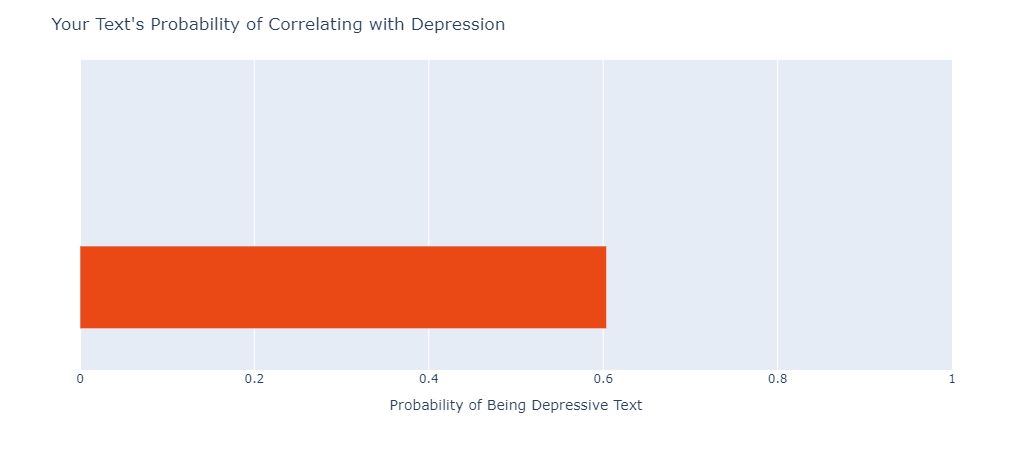

In [199]:
if prediction < 0.2:
    color='#27B240'
elif 0.2 <= prediction < 0.4:
    color='#F0D637'
elif 0.4 <= prediction < 0.6:
    color = '#F08837'
elif 0.6 <= prediction < 0.8:
    color = '#EA4915'
else:
    color = '#970000'


df = pd.DataFrame({'Probability of Being Depressive Text':prediction},index=['P'])
fig = px.bar(df, 
             y=[0.8], 
             x="Probability of Being Depressive Text", 
             orientation='h',
             range_x=[0,1],
             range_y=[0,3],
             color_discrete_sequence =[f'{color}'],
             barmode='group')
fig.update_yaxes(showticklabels=False)
fig.update_layout(title_text="Your Text's Probability of Correlating with Depression")
fig.update_yaxes(title_text='')

fig.show()

In [175]:
df

,Probability of Being Depressive Text
P,0.603908
